# Elastic Modulus Calculation for SnowPilot Dataset

This notebook demonstrates calculating elastic modulus for the SnowPilot dataset using all available calculation pathways.

## Overview

Elastic modulus depends on density, so the execution engine builds calculation chains:

**Density pathways (intermediate):**
1. Direct measurement (`data_flow`)
2. Geldsetzer method (hand hardness + grain form)
3. Kim-Jamieson Table 2 (hand hardness + grain form)
4. Kim-Jamieson Table 5 (hand hardness + grain form + grain size)

**Elastic modulus methods (each can use any density pathway):**
1. **Bergfeld** - Based on density and grain form
2. **Kochle** - Based on density and grain form
3. **Wautier** - Based on density and grain form
4. **Schottner** - Based on density and grain form

This creates 4 density pathways × 4 elastic modulus methods = **16 possible calculation pathways**.

## 1. Setup and Imports

In [1]:
import os
import sys
from collections import defaultdict
from typing import Dict, List, Optional, Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Add paths for imports
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, os.path.join(os.getcwd(), '..', 'algorithm'))

# Import snowpilot utilities
from snowpilot_utils import parse_sample_pits, pit_to_slab_above_weak_layer

# Import data structures
from snowpyt_mechparams.data_structures import Layer, Slab

# Import execution engine
from snowpyt_mechparams.execution import ExecutionEngine, ExecutionResults

# Import the algorithm graph
from definitions import graph

print("Imports successful!")

Imports successful!


/Users/marykate/Desktop/Snow/SnowPyt-MechParams/venv/lib/python3.14/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


## 2. Load SnowPilot Data

In [2]:
# Configuration: Set the number of pits to process
# Set to None to process all pits (warning: may take a long time for 50k+ pits)
MAX_PITS = 500  # Change to None for all pits

# Parse all XML files
data_folder = os.path.join(os.getcwd(), 'data')
print(f"Loading pits from: {data_folder}")
all_pits = parse_sample_pits(data_folder)

Loading pits from: /Users/marykate/Desktop/Snow/SnowPyt-MechParams/examples/data
Successfully parsed 50278 files
Failed to parse 0 files


In [3]:
# Limit to MAX_PITS if specified
if MAX_PITS is not None:
    pits_to_process = all_pits[:MAX_PITS]
    print(f"Processing {len(pits_to_process)} of {len(all_pits)} available pits")
else:
    pits_to_process = all_pits
    print(f"Processing all {len(pits_to_process)} pits")

Processing 500 of 50278 available pits


## 3. Convert Pits to Slabs

In [4]:
# Convert pits to slabs (no weak layer filtering - get all layers)
slabs = []
pit_ids = []

for i, pit in enumerate(pits_to_process):
    try:
        slab = pit_to_slab_above_weak_layer(pit, weak_layer_def=None)
        if slab and slab.layers:
            slabs.append(slab)
            pit_id = getattr(pit.core_info, 'name', None) or f"pit_{i}"
            pit_ids.append(pit_id)
    except Exception as e:
        pass

print(f"Converted {len(slabs)} pits to slabs")
total_layers = sum(len(s.layers) for s in slabs)
print(f"Total layers across all slabs: {total_layers}")

Converted 500 pits to slabs
Total layers across all slabs: 3662


## 4. Explore Available Elastic Modulus Calculation Pathways

In [5]:
# Initialize the execution engine
engine = ExecutionEngine(graph)

# List all available pathways for elastic modulus
pathways = engine.list_available_pathways("elastic_modulus")

print(f"Found {len(pathways)} pathways for calculating elastic modulus:\n")
for i, p in enumerate(pathways, 1):
    print(f"{i:2d}. {p['description']}")
    print(f"    Methods chain: {' -> '.join(p['methods'])}")
    print()

Found 16 pathways for calculating elastic modulus:

 1. density=data_flow | elastic_modulus=bergfeld
    Methods chain: density -> elastic_modulus

 2. density=geldsetzer | elastic_modulus=bergfeld
    Methods chain: density -> elastic_modulus

 3. density=kim_jamieson_table2 | elastic_modulus=bergfeld
    Methods chain: density -> elastic_modulus

 4. density=kim_jamieson_table5 | elastic_modulus=bergfeld
    Methods chain: density -> elastic_modulus

 5. density=data_flow | elastic_modulus=kochle
    Methods chain: density -> elastic_modulus

 6. density=geldsetzer | elastic_modulus=kochle
    Methods chain: density -> elastic_modulus

 7. density=kim_jamieson_table2 | elastic_modulus=kochle
    Methods chain: density -> elastic_modulus

 8. density=kim_jamieson_table5 | elastic_modulus=kochle
    Methods chain: density -> elastic_modulus

 9. density=data_flow | elastic_modulus=wautier
    Methods chain: density -> elastic_modulus

10. density=geldsetzer | elastic_modulus=wautier
  

## 5. Execute All Elastic Modulus Pathways

In [6]:
# Store results for all slabs
all_results: Dict[str, ExecutionResults] = {}

print(f"Executing elastic modulus calculations on {len(slabs)} slabs...")
print("(This may take a while for large datasets)\n")

for i, (pit_id, slab) in enumerate(zip(pit_ids, slabs)):
    # Execute all elastic modulus pathways for this slab
    results = engine.execute_all(
        slab=slab,
        target_parameter="elastic_modulus",
        include_plate_theory=False
    )
    all_results[pit_id] = results
    
    if (i + 1) % 100 == 0:
        print(f"  Processed {i + 1}/{len(slabs)} slabs...")

print(f"\nCompleted processing {len(all_results)} slabs!")

Executing elastic modulus calculations on 500 slabs...
(This may take a while for large datasets)

  Processed 100/500 slabs...
  Processed 200/500 slabs...
  Processed 300/500 slabs...
  Processed 400/500 slabs...
  Processed 500/500 slabs...

Completed processing 500 slabs!


## 6. Analyze Results by Pathway

In [7]:
# Aggregate statistics by pathway
pathway_stats = defaultdict(lambda: {
    'total_slabs': 0,
    'successful_slabs': 0,
    'total_layers': 0,
    'successful_layers': 0,
    'elastic_modulus_values': [],
    'density_values': []  # Track intermediate density too
})

for pit_id, exec_results in all_results.items():
    for pathway_desc, pathway_result in exec_results.results.items():
        stats = pathway_stats[pathway_desc]
        stats['total_slabs'] += 1
        
        if pathway_result.success:
            stats['successful_slabs'] += 1
        
        for layer_result in pathway_result.layer_results:
            stats['total_layers'] += 1
            layer = layer_result.layer
            
            # Check elastic modulus
            em_val = layer.elastic_modulus
            if em_val is not None:
                stats['successful_layers'] += 1
                if hasattr(em_val, 'nominal_value'):
                    if not np.isnan(em_val.nominal_value):
                        stats['elastic_modulus_values'].append(em_val.nominal_value)
                elif isinstance(em_val, (int, float)) and not np.isnan(em_val):
                    stats['elastic_modulus_values'].append(float(em_val))
            
            # Track density used
            density_val = layer.density_calculated or layer.density_measured
            if density_val is not None:
                if hasattr(density_val, 'nominal_value'):
                    if not np.isnan(density_val.nominal_value):
                        stats['density_values'].append(density_val.nominal_value)
                elif isinstance(density_val, (int, float)) and not np.isnan(density_val):
                    stats['density_values'].append(float(density_val))

# Display summary
print("=" * 90)
print("ELASTIC MODULUS PATHWAY SUCCESS RATES")
print("=" * 90)

for pathway_desc, stats in sorted(pathway_stats.items()):
    slab_rate = stats['successful_slabs'] / stats['total_slabs'] * 100 if stats['total_slabs'] > 0 else 0
    layer_rate = stats['successful_layers'] / stats['total_layers'] * 100 if stats['total_layers'] > 0 else 0
    
    print(f"\n{pathway_desc}")
    print(f"  Slab success:  {stats['successful_slabs']:,}/{stats['total_slabs']:,} ({slab_rate:.1f}%)")
    print(f"  Layer success: {stats['successful_layers']:,}/{stats['total_layers']:,} ({layer_rate:.1f}%)")
    
    if stats['elastic_modulus_values']:
        vals = stats['elastic_modulus_values']
        # Convert to MPa for readability
        vals_mpa = [v / 1e6 for v in vals]
        print(f"  E statistics: mean={np.mean(vals_mpa):.2f}, std={np.std(vals_mpa):.2f}, "
              f"min={np.min(vals_mpa):.2f}, max={np.max(vals_mpa):.2f} MPa")

ELASTIC MODULUS PATHWAY SUCCESS RATES

density=data_flow | elastic_modulus=bergfeld
  Slab success:  0/500 (0.0%)
  Layer success: 0/3,662 (0.0%)

density=data_flow | elastic_modulus=kochle
  Slab success:  0/500 (0.0%)
  Layer success: 0/3,662 (0.0%)

density=data_flow | elastic_modulus=schottner
  Slab success:  0/500 (0.0%)
  Layer success: 0/3,662 (0.0%)

density=data_flow | elastic_modulus=wautier
  Slab success:  0/500 (0.0%)
  Layer success: 0/3,662 (0.0%)

density=geldsetzer | elastic_modulus=bergfeld
  Slab success:  349/500 (69.8%)
  Layer success: 836/3,662 (22.8%)
  E statistics: mean=0.00, std=0.00, min=0.00, max=0.00 MPa

density=geldsetzer | elastic_modulus=kochle
  Slab success:  304/500 (60.8%)
  Layer success: 656/3,662 (17.9%)
  E statistics: mean=0.00, std=0.00, min=0.00, max=0.00 MPa

density=geldsetzer | elastic_modulus=schottner
  Slab success:  434/500 (86.8%)
  Layer success: 1,770/3,662 (48.3%)
  E statistics: mean=0.00, std=0.00, min=0.00, max=0.00 MPa

densi

## 7. Compare Elastic Modulus Methods

Group results by the elastic modulus method (bergfeld, kochle, wautier, schottner) to see how they compare.

In [8]:
# Group by elastic modulus method
method_stats = defaultdict(lambda: {'values': [], 'densities': []})

for pathway_desc, stats in pathway_stats.items():
    # Extract the elastic modulus method name from the pathway description
    # Format is like "density=geldsetzer -> elastic_modulus=bergfeld"
    if 'elastic_modulus=' in pathway_desc:
        em_method = pathway_desc.split('elastic_modulus=')[-1].strip()
        method_stats[em_method]['values'].extend(stats['elastic_modulus_values'])
        method_stats[em_method]['densities'].extend(stats['density_values'])

print("\n" + "=" * 70)
print("ELASTIC MODULUS BY METHOD (aggregated across all density pathways)")
print("=" * 70)

for method, data in sorted(method_stats.items()):
    if data['values']:
        vals_mpa = [v / 1e6 for v in data['values']]
        print(f"\n{method.upper()}:")
        print(f"  N = {len(vals_mpa):,} layers")
        print(f"  Mean: {np.mean(vals_mpa):.2f} MPa")
        print(f"  Std:  {np.std(vals_mpa):.2f} MPa")
        print(f"  Range: {np.min(vals_mpa):.2f} - {np.max(vals_mpa):.2f} MPa")
        print(f"  Median: {np.median(vals_mpa):.2f} MPa")


ELASTIC MODULUS BY METHOD (aggregated across all density pathways)

BERGFELD:
  N = 1,842 layers
  Mean: 0.00 MPa
  Std:  0.00 MPa
  Range: 0.00 - 0.00 MPa
  Median: 0.00 MPa

KOCHLE:
  N = 1,787 layers
  Mean: 0.00 MPa
  Std:  0.00 MPa
  Range: 0.00 - 0.00 MPa
  Median: 0.00 MPa

SCHOTTNER:
  N = 4,326 layers
  Mean: 0.00 MPa
  Std:  0.00 MPa
  Range: 0.00 - 0.00 MPa
  Median: 0.00 MPa

WAUTIER:
  N = 4,551 layers
  Mean: 0.00 MPa
  Std:  0.00 MPa
  Range: 0.00 - 0.00 MPa
  Median: 0.00 MPa


## 8. Visualize Elastic Modulus Distributions

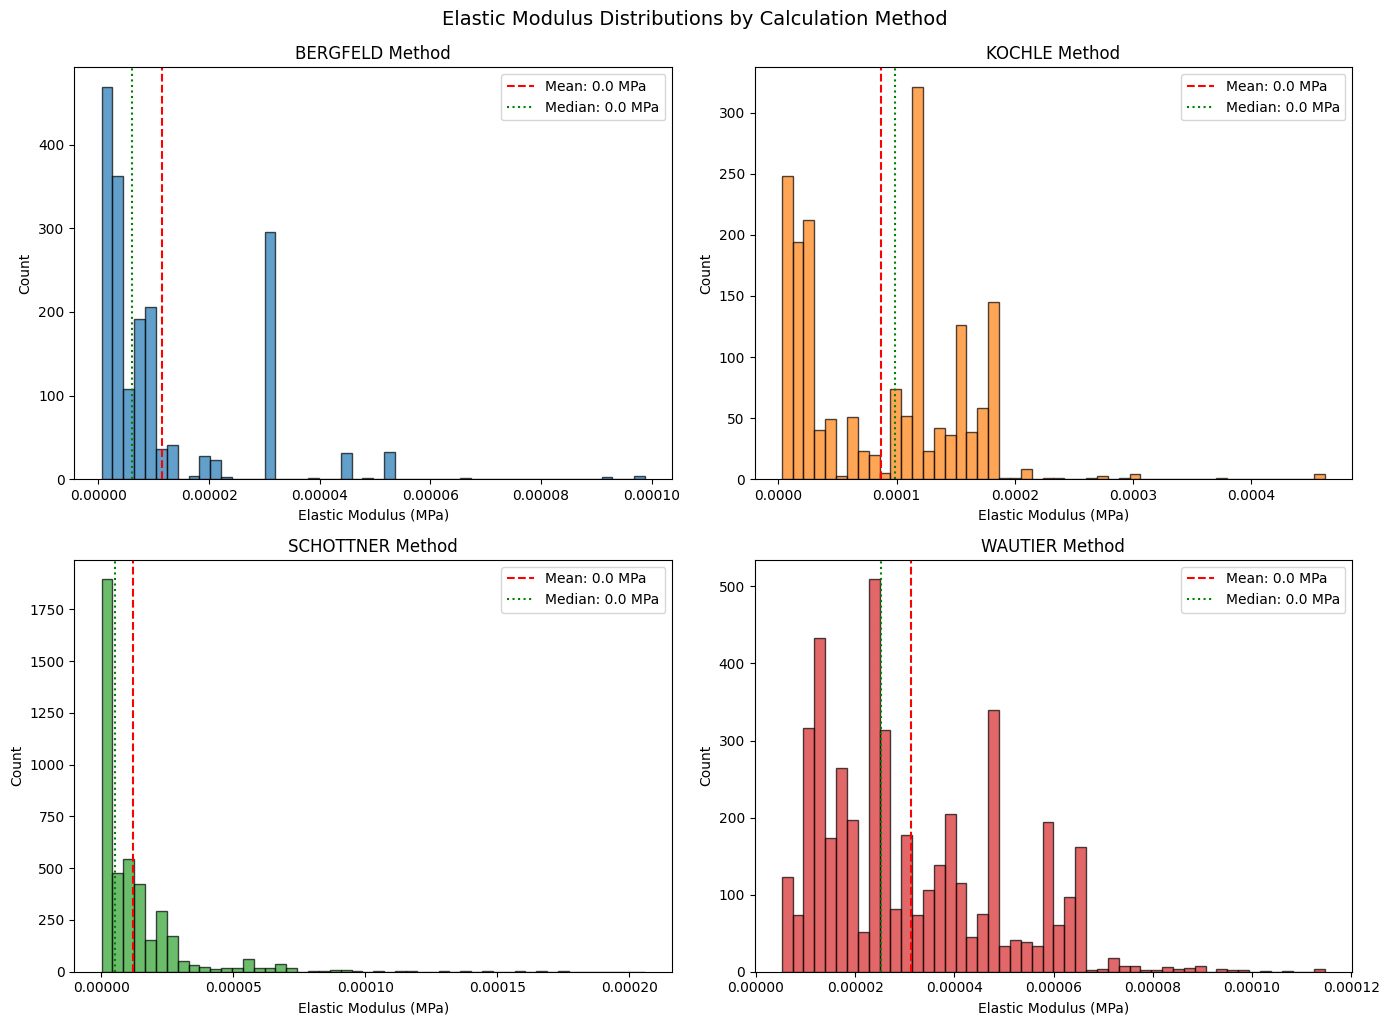

In [9]:
# Create histograms for each elastic modulus method
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for idx, (method, data) in enumerate(sorted(method_stats.items())):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    if data['values']:
        vals_mpa = [v / 1e6 for v in data['values']]
        ax.hist(vals_mpa, bins=50, edgecolor='black', alpha=0.7, color=colors[idx])
        ax.axvline(np.mean(vals_mpa), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(vals_mpa):.1f} MPa')
        ax.axvline(np.median(vals_mpa), color='green', linestyle=':', 
                   label=f'Median: {np.median(vals_mpa):.1f} MPa')
        ax.set_xlabel('Elastic Modulus (MPa)')
        ax.set_ylabel('Count')
        ax.legend()
    else:
        ax.text(0.5, 0.5, 'No successful calculations', 
                ha='center', va='center', transform=ax.transAxes)
    
    ax.set_title(f'{method.upper()} Method', fontsize=12)

plt.tight_layout()
plt.suptitle('Elastic Modulus Distributions by Calculation Method', y=1.02, fontsize=14)
plt.show()

/var/folders/57/k667mldd16lclkdl7fjck83m0000gn/T/ipykernel_6441/4041587943.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=labels, patch_artist=True)


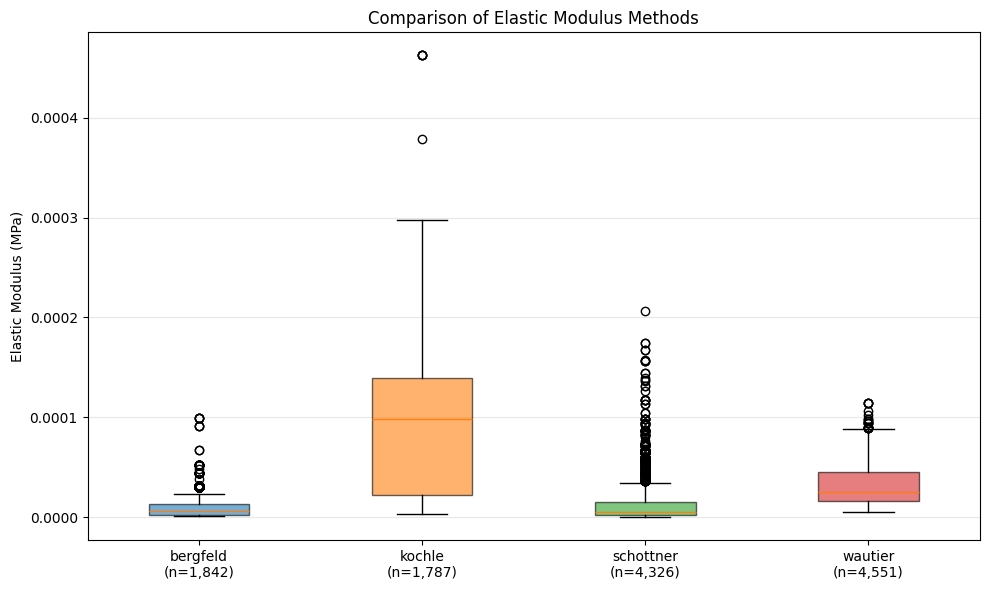

In [10]:
# Box plot comparison of methods
fig, ax = plt.subplots(figsize=(10, 6))

box_data = []
labels = []

for method, data in sorted(method_stats.items()):
    if data['values']:
        vals_mpa = [v / 1e6 for v in data['values']]
        box_data.append(vals_mpa)
        labels.append(f"{method}\n(n={len(vals_mpa):,})")

if box_data:
    bp = ax.boxplot(box_data, labels=labels, patch_artist=True)
    
    for patch, color in zip(bp['boxes'], colors[:len(box_data)]):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)
    
    ax.set_ylabel('Elastic Modulus (MPa)')
    ax.set_title('Comparison of Elastic Modulus Methods')
    ax.grid(axis='y', alpha=0.3)
    
plt.tight_layout()
plt.show()

## 9. Elastic Modulus vs Density Relationship

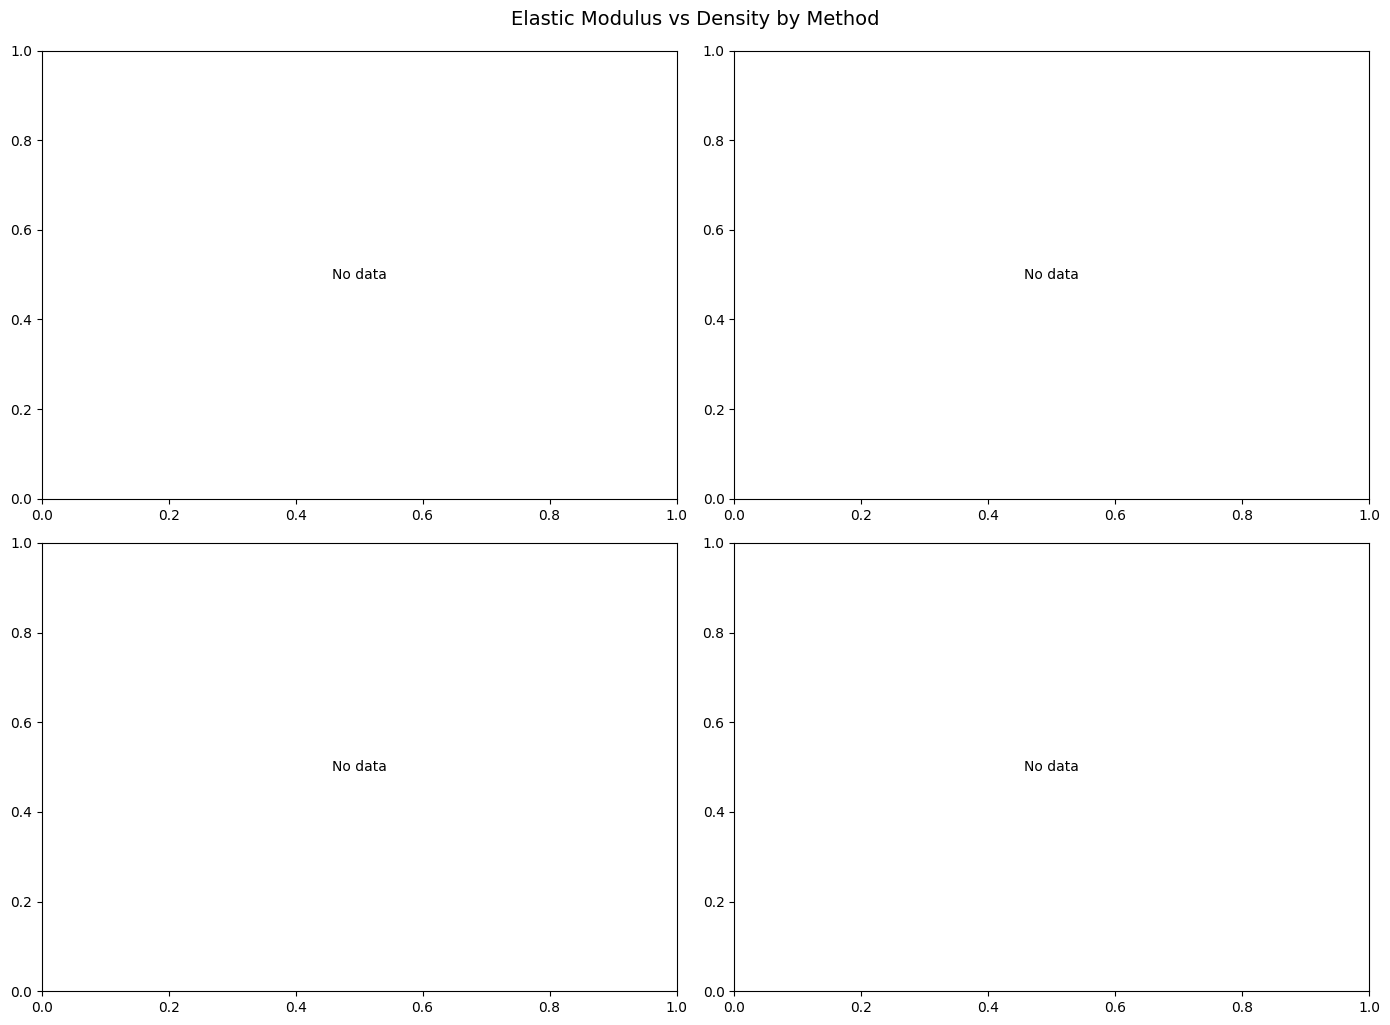

In [11]:
# Scatter plot: Elastic modulus vs Density by method
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (method, data) in enumerate(sorted(method_stats.items())):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    
    # Need to pair up density and elastic modulus values
    # Collect from individual pathways for this method
    e_vals = []
    d_vals = []
    
    for pathway_desc, stats in pathway_stats.items():
        if f'elastic_modulus={method}' in pathway_desc:
            for pit_id, exec_results in all_results.items():
                if pathway_desc in exec_results.results:
                    pr = exec_results.results[pathway_desc]
                    for lr in pr.layer_results:
                        layer = lr.layer
                        em_val = layer.elastic_modulus
                        d_val = layer.density_calculated or layer.density_measured
                        
                        if em_val is not None and d_val is not None:
                            em = em_val.nominal_value if hasattr(em_val, 'nominal_value') else em_val
                            d = d_val.nominal_value if hasattr(d_val, 'nominal_value') else d_val
                            
                            if not np.isnan(em) and not np.isnan(d):
                                e_vals.append(em / 1e6)  # Convert to MPa
                                d_vals.append(d)
            break  # Only need one pathway per method for the scatter
    
    if e_vals and d_vals:
        ax.scatter(d_vals, e_vals, alpha=0.3, s=10, color=colors[idx])
        ax.set_xlabel('Density (kg/m³)')
        ax.set_ylabel('Elastic Modulus (MPa)')
        ax.set_title(f'{method.upper()} Method')
        
        # Add correlation coefficient
        corr = np.corrcoef(d_vals, e_vals)[0, 1]
        ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
                fontsize=10, verticalalignment='top')
    else:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.suptitle('Elastic Modulus vs Density by Method', y=1.02, fontsize=14)
plt.show()

## 10. Compare Density Estimation Impact on Elastic Modulus

How does the choice of density estimation method affect the final elastic modulus?

In [12]:
# Group by density method for a single elastic modulus method (bergfeld)
density_method_impact = defaultdict(list)

target_em_method = 'bergfeld'  # Focus on one E method

for pathway_desc, stats in pathway_stats.items():
    if f'elastic_modulus={target_em_method}' in pathway_desc:
        # Extract density method
        if 'density=' in pathway_desc:
            density_method = pathway_desc.split('density=')[1].split(' ->')[0].strip()
            density_method_impact[density_method].extend(
                [v / 1e6 for v in stats['elastic_modulus_values']]
            )

print(f"\nImpact of Density Method on {target_em_method.upper()} Elastic Modulus:")
print("=" * 60)

for dm, vals in sorted(density_method_impact.items()):
    if vals:
        print(f"\n{dm}:")
        print(f"  N = {len(vals):,}")
        print(f"  Mean E = {np.mean(vals):.2f} MPa")
        print(f"  Std E  = {np.std(vals):.2f} MPa")


Impact of Density Method on BERGFELD Elastic Modulus:

geldsetzer | elastic_modulus=bergfeld:
  N = 836
  Mean E = 0.00 MPa
  Std E  = 0.00 MPa

kim_jamieson_table2 | elastic_modulus=bergfeld:
  N = 835
  Mean E = 0.00 MPa
  Std E  = 0.00 MPa

kim_jamieson_table5 | elastic_modulus=bergfeld:
  N = 171
  Mean E = 0.00 MPa
  Std E  = 0.00 MPa


/var/folders/57/k667mldd16lclkdl7fjck83m0000gn/T/ipykernel_6441/568186325.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=labels, patch_artist=True)


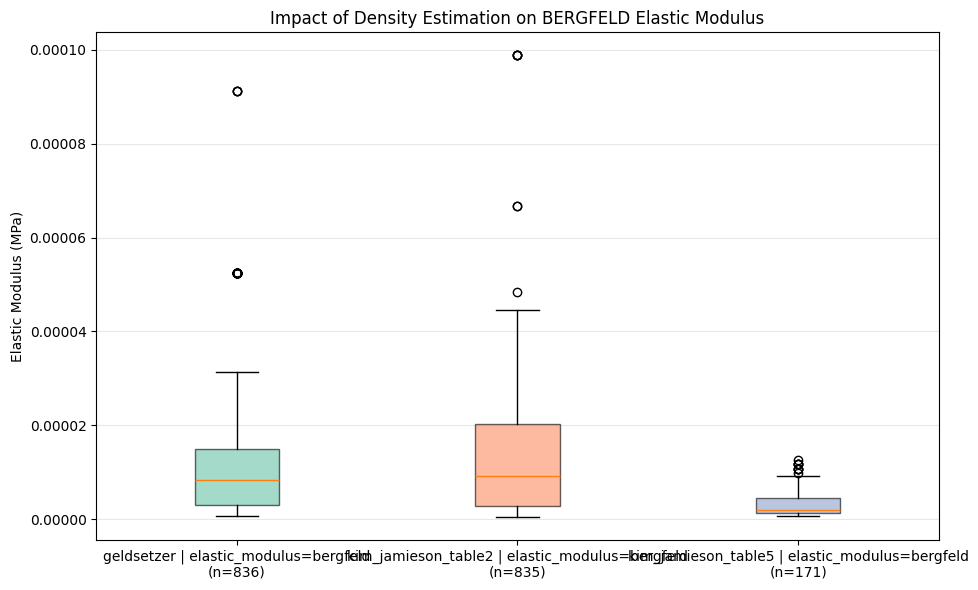

In [13]:
# Box plot showing impact of density method
if density_method_impact:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    box_data = []
    labels = []
    
    for dm, vals in sorted(density_method_impact.items()):
        if vals:
            box_data.append(vals)
            labels.append(f"{dm}\n(n={len(vals):,})")
    
    if box_data:
        bp = ax.boxplot(box_data, labels=labels, patch_artist=True)
        
        for patch, color in zip(bp['boxes'], plt.cm.Set2.colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        
        ax.set_ylabel('Elastic Modulus (MPa)')
        ax.set_title(f'Impact of Density Estimation on {target_em_method.upper()} Elastic Modulus')
        ax.grid(axis='y', alpha=0.3)
        
    plt.tight_layout()
    plt.show()

## 11. Detailed Results for a Single Slab

In [14]:
# Pick a slab with multiple layers and successful calculations
sample_pit_id = None
for pid, results in all_results.items():
    if results.source_slab and len(results.source_slab.layers) >= 3:
        if results.successful_pathways > 0:
            sample_pit_id = pid
            break

if sample_pit_id:
    sample_results = all_results[sample_pit_id]
    print(f"Detailed results for pit: {sample_pit_id}")
    print(f"Number of layers: {len(sample_results.source_slab.layers)}")
    print(f"Pathways attempted: {sample_results.total_pathways}")
    print(f"Successful pathways: {sample_results.successful_pathways}")
    print()
    
    # Show first few successful pathways
    shown = 0
    for pathway_desc, pathway_result in sample_results.results.items():
        if pathway_result.success and shown < 3:
            print(f"\n{'=' * 70}")
            print(f"Pathway: {pathway_desc}")
            print(f"Methods: {pathway_result.methods_used}")
            print()
            
            print("Layer results:")
            for lr in pathway_result.layer_results:
                layer = lr.layer
                
                # Format density
                d = layer.density_calculated or layer.density_measured
                if d is not None:
                    d_str = f"{d.nominal_value:.1f}" if hasattr(d, 'nominal_value') else f"{d:.1f}"
                else:
                    d_str = "None"
                
                # Format elastic modulus
                e = layer.elastic_modulus
                if e is not None:
                    e_mpa = e.nominal_value / 1e6 if hasattr(e, 'nominal_value') else e / 1e6
                    e_str = f"{e_mpa:.2f} MPa"
                else:
                    e_str = "None"
                
                print(f"  Layer {lr.layer_index}: depth={layer.depth_top}, "
                      f"grain={layer.grain_form}, density={d_str} kg/m³, E={e_str}")
            
            shown += 1
else:
    print("No suitable sample slab found")

Detailed results for pit: pit_0
Number of layers: 7
Pathways attempted: 16
Successful pathways: 8


Pathway: density=geldsetzer | elastic_modulus=bergfeld
Methods: {'density': 'geldsetzer', 'elastic_modulus': 'bergfeld'}

Layer results:
  Layer 0: depth=0.0, grain=None, density=None kg/m³, E=None
  Layer 1: depth=30.0, grain=PP, density=None kg/m³, E=None
  Layer 2: depth=40.0, grain=None, density=None kg/m³, E=None
  Layer 3: depth=60.0, grain=DF, density=112.9 kg/m³, E=0.00 MPa
  Layer 4: depth=70.0, grain=None, density=None kg/m³, E=None
  Layer 5: depth=105.0, grain=FC, density=173.2 kg/m³, E=None
  Layer 6: depth=110.0, grain=None, density=None kg/m³, E=None

Pathway: density=kim_jamieson_table2 | elastic_modulus=bergfeld
Methods: {'density': 'kim_jamieson_table2', 'elastic_modulus': 'bergfeld'}

Layer results:
  Layer 0: depth=0.0, grain=None, density=None kg/m³, E=None
  Layer 1: depth=30.0, grain=PP, density=None kg/m³, E=None
  Layer 2: depth=40.0, grain=None, density=None kg/

## 12. Export Results to DataFrame

In [15]:
# Create comprehensive results dataframe
export_data = []

for pit_id, exec_results in all_results.items():
    for pathway_desc, pathway_result in exec_results.results.items():
        # Parse pathway to extract methods
        density_method = None
        em_method = None
        if 'density=' in pathway_desc:
            density_method = pathway_desc.split('density=')[1].split(' ->')[0].strip()
        if 'elastic_modulus=' in pathway_desc:
            em_method = pathway_desc.split('elastic_modulus=')[-1].strip()
        
        for lr in pathway_result.layer_results:
            layer = lr.layer
            
            # Get density
            d_val = layer.density_calculated or layer.density_measured
            if d_val is not None:
                d_nom = d_val.nominal_value if hasattr(d_val, 'nominal_value') else float(d_val)
                d_std = d_val.std_dev if hasattr(d_val, 'std_dev') else 0.0
            else:
                d_nom, d_std = np.nan, np.nan
            
            # Get elastic modulus
            e_val = layer.elastic_modulus
            if e_val is not None:
                e_nom = e_val.nominal_value if hasattr(e_val, 'nominal_value') else float(e_val)
                e_std = e_val.std_dev if hasattr(e_val, 'std_dev') else 0.0
            else:
                e_nom, e_std = np.nan, np.nan
            
            export_data.append({
                'pit_id': pit_id,
                'pathway': pathway_desc,
                'density_method': density_method,
                'elastic_modulus_method': em_method,
                'layer_index': lr.layer_index,
                'depth_top': layer.depth_top,
                'thickness': layer.thickness,
                'hand_hardness': layer.hand_hardness,
                'grain_form': layer.grain_form,
                'grain_form_sub': layer.grain_form_sub,
                'density_kg_m3': d_nom,
                'density_uncertainty': d_std,
                'elastic_modulus_Pa': e_nom,
                'elastic_modulus_MPa': e_nom / 1e6 if not np.isnan(e_nom) else np.nan,
                'elastic_modulus_uncertainty': e_std,
                'pathway_success': pathway_result.success
            })

results_df = pd.DataFrame(export_data)
print(f"Created DataFrame with {len(results_df)} rows")
print(f"Columns: {list(results_df.columns)}")
results_df.head(10)

TypeError: float() argument must be a string or a real number, not 'list'

In [ ]:
# Summary by method combination
summary = results_df.groupby(['density_method', 'elastic_modulus_method']).agg({
    'elastic_modulus_MPa': ['count', 'mean', 'std', 'min', 'max']
}).round(2)

summary.columns = ['N', 'Mean (MPa)', 'Std (MPa)', 'Min (MPa)', 'Max (MPa)']
print("\nSummary by Method Combination:")
print(summary.to_string())

In [ ]:
# Optional: Save to CSV
# Uncomment the following line to save results
# results_df.to_csv('elastic_modulus_results.csv', index=False)
# print("Saved to elastic_modulus_results.csv")

## Summary

This notebook demonstrated:

1. **Chained calculations** - Elastic modulus requires density, so the engine builds 16 pathways (4 density methods × 4 E methods)

2. **Method comparison** - The four elastic modulus methods (Bergfeld, Kochle, Wautier, Schottner) produce different distributions

3. **Density method impact** - The choice of density estimation affects the final elastic modulus values

4. **E-density relationship** - Strong correlation between density and elastic modulus across all methods

### Key Observations

- Elastic modulus calculations require both **density** and **grain form**
- Methods differ in their formulas and grain form handling
- Measured density (when available) vs estimated density can lead to different E values
- The Bergfeld and Wautier methods tend to produce different ranges than Kochle and Schottner